In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [2]:
NUM_EPOCHS = 10

## Load the data

In [3]:
training_dir = 'chest_xray/chest_xray/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_dir,
  seed=123,
  image_size=(200,200),
  batch_size=4)

validation_dir = 'chest_xray/chest_xray/val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  seed=123,
  image_size=(200,200),
  batch_size=4)

testing_dir = 'chest_xray/chest_xray/test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testing_dir,
  seed=123,
  image_size=(200,200),
  batch_size=4)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [4]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(4, 200, 200, 3)
(4,)


## Standardize the data

In [5]:
# Instatiate the normalization layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

## Configure dataset for performance

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_tensors = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_tensors = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a model

Epoch 1/10
1304/1304 [==============================] - 266s 204ms/step - loss: 0.2109 - accuracy: 0.9273 - val_loss: 0.2813 - val_accuracy: 0.8750
Epoch 2/10
1304/1304 [==============================] - 263s 201ms/step - loss: 0.1124 - accuracy: 0.9607 - val_loss: 0.3062 - val_accuracy: 0.9375
Epoch 3/10
1304/1304 [==============================] - 260s 199ms/step - loss: 0.0573 - accuracy: 0.9804 - val_loss: 0.3465 - val_accuracy: 0.7500
Epoch 4/10
1304/1304 [==============================] - 266s 204ms/step - loss: 0.0427 - accuracy: 0.9839 - val_loss: 0.2730 - val_accuracy: 0.8750
Epoch 5/10
1304/1304 [==============================] - 265s 204ms/step - loss: 0.0369 - accuracy: 0.9873 - val_loss: 0.0572 - val_accuracy: 1.0000
Epoch 6/10
1304/1304 [==============================] - 265s 203ms/step - loss: 0.0179 - accuracy: 0.9948 - val_loss: 0.6294 - val_accuracy: 0.6875
Epoch 7/10
1304/1304 [==============================] - 265s 203ms/step - loss: 0.0135 - accuracy: 0.9952 - val_

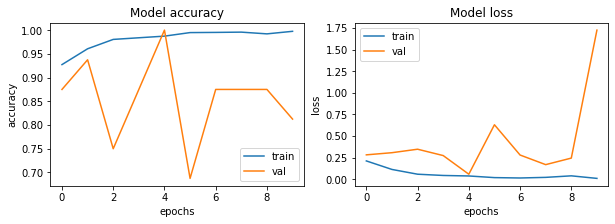

In [7]:
num_classes = 1

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(
  optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=NUM_EPOCHS
)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [8]:
# TEST

import cv2
from sklearn.metrics import accuracy_score, confusion_matrix

# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

input_path = 'chest_xray/chest_xray/'

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (200, 200))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

preds = model.predict(test_ds)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))


CONFUSION MATRIX ------------------
[[ 12 222]
 [ 28 362]]

TEST METRICS ----------------------
Accuracy: 59.93589743589743%
Precision: 61.986301369863014%
Recall: 92.82051282051282%
F1-score: 74.33264887063655

TRAIN METRIC ----------------------
Train acc: 99.75


### To Do
* [ ] Change batch size
* [ ] Implement drop out
* [ ] Explore other model architectures
    * [ ] Convolutional NN

## Change batch size

###### Batch size should be large enough so that each batch has enough of a chance to see enough of each label.
###### Remember that there are 3 times as many 'PNEUMONIA' labels as there are 'NORMAL'

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Epoch 1/10
82/82 [==============================] - 177s 2s/step - loss: 0.4610 - accuracy: 0.8115 - val_loss: 0.4206 - val_accuracy: 0.7500
Epoch 2/10
82/82 [==============================] - 179s 2s/step - loss: 0.1164 - accuracy: 0.9572 - val_loss: 0.3530 - val_accuracy: 0.8125
Epoch 3/10
82/82 [==============================] - 175s 2s/step - loss: 0.0925 - accuracy: 0.9670 - val_loss: 0.2569 - val_accuracy: 0.9375
Epoch 4/10
82/82 [==============================] - 176s 2s/step - loss: 0.0649 - accuracy: 0.9755 - val_loss: 0.6324 - val_accuracy: 0.6875
Epoch 5/10
82/82 [==============================] - 175s 2s/step - loss: 0.0571 - accuracy: 0.9787 - val_loss: 0.1261 - val_accuracy: 0.9375
Epoch 6/10
82/82 [==============================] - 177s 2s/step - loss: 0.0377 - accuracy: 0.9862 - val_loss: 0.2794 - val_accuracy: 0.8750
Epoch 7/10
82/82 [================

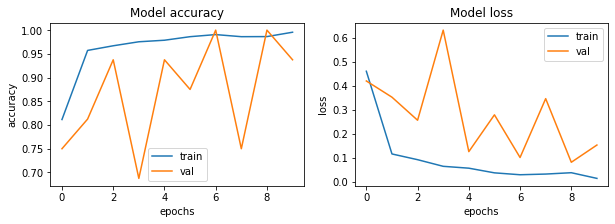

In [9]:
BATCH_SIZE = 64

training_dir = 'chest_xray/chest_xray/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_dir,
  seed=123,
  image_size=(200,200),
  batch_size=BATCH_SIZE)

validation_dir = 'chest_xray/chest_xray/val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  seed=123,
  image_size=(200,200),
  batch_size=BATCH_SIZE)

testing_dir = 'chest_xray/chest_xray/test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testing_dir,
  seed=123,
  image_size=(200,200),
  batch_size=BATCH_SIZE)

# Instatiate the normalization layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_tensors = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_tensors = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 1

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(
  optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=NUM_EPOCHS
)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [10]:
# TEST

import cv2
from sklearn.metrics import accuracy_score, confusion_matrix

# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

input_path = 'chest_xray/chest_xray/'

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (200, 200))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

preds = model.predict(test_ds)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))


CONFUSION MATRIX ------------------
[[ 19 215]
 [ 54 336]]

TEST METRICS ----------------------
Accuracy: 56.891025641025635%
Precision: 60.98003629764065%
Recall: 86.15384615384616%
F1-score: 71.413390010627

TRAIN METRIC ----------------------
Train acc: 99.56


## Use dropout

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Epoch 1/10
82/82 [==============================] - 195s 2s/step - loss: 1.1476 - accuracy: 0.7157 - val_loss: 0.6827 - val_accuracy: 0.5000
Epoch 2/10
82/82 [==============================] - 196s 2s/step - loss: 0.2581 - accuracy: 0.8963 - val_loss: 0.4499 - val_accuracy: 0.8125
Epoch 3/10
82/82 [==============================] - 195s 2s/step - loss: 0.1765 - accuracy: 0.9279 - val_loss: 0.4206 - val_accuracy: 0.7500
Epoch 4/10
82/82 [==============================] - 196s 2s/step - loss: 0.1525 - accuracy: 0.9434 - val_loss: 0.6882 - val_accuracy: 0.6250
Epoch 5/10
82/82 [==============================] - 196s 2s/step - loss: 0.1414 - accuracy: 0.9459 - val_loss: 0.4023 - val_accuracy: 0.7500
Epoch 6/10
82/82 [==============================] - 196s 2s/step - loss: 0.1120 - accuracy: 0.9580 - val_loss: 0.3942 - val_accuracy: 0.7500
Epoch 7/10
82/82 [==============================] - 196s 2s/step - loss: 0

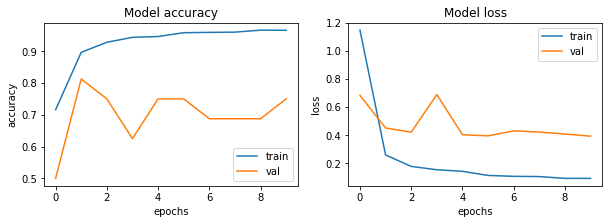

In [11]:
BATCH_SIZE = 64

training_dir = 'chest_xray/chest_xray/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_dir,
  seed=123,
  image_size=(200,200),
  batch_size=BATCH_SIZE)

validation_dir = 'chest_xray/chest_xray/val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  seed=123,
  image_size=(200,200),
  batch_size=BATCH_SIZE)

# Instatiate the normalization layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_tensors = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_tensors = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Dropout(rate=0.2),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate=0.5),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate=0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(
  optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=NUM_EPOCHS
)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
# TEST

import cv2
from sklearn.metrics import accuracy_score, confusion_matrix

# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

input_path = 'chest_xray/chest_xray/'

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (200, 200))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

preds = model.predict(test_ds)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))


CONFUSION MATRIX ------------------
[[ 28 206]
 [ 46 344]]

TEST METRICS ----------------------
Accuracy: 59.61538461538461%
Precision: 62.54545454545455%
Recall: 88.2051282051282%
F1-score: 73.19148936170212

TRAIN METRIC ----------------------
Train acc: 96.55


## Stack Conv2D Layers (No Dropout)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Epoch 1/10
82/82 [==============================] - 500s 6s/step - loss: 0.2755 - accuracy: 0.8859 - val_loss: 0.9046 - val_accuracy: 0.6250
Epoch 2/10
82/82 [==============================] - 496s 6s/step - loss: 0.1106 - accuracy: 0.9586 - val_loss: 0.3619 - val_accuracy: 0.8125
Epoch 3/10
82/82 [==============================] - 496s 6s/step - loss: 0.1033 - accuracy: 0.9607 - val_loss: 0.3195 - val_accuracy: 0.8750
Epoch 4/10
82/82 [==============================] - 496s 6s/step - loss: 0.0647 - accuracy: 0.9743 - val_loss: 0.1869 - val_accuracy: 0.9375
Epoch 5/10
82/82 [==============================] - 497s 6s/step - loss: 0.0426 - accuracy: 0.9860 - val_loss: 0.2559 - val_accuracy: 0.8125
Epoch 6/10
82/82 [==============================] - 497s 6s/step - loss: 0.0336 - accuracy: 0.9873 - val_loss: 0.1831 - val_accuracy: 0.8750
Epoch 7/10
82/82 [==============================] - 497s 6s/step - loss: 0

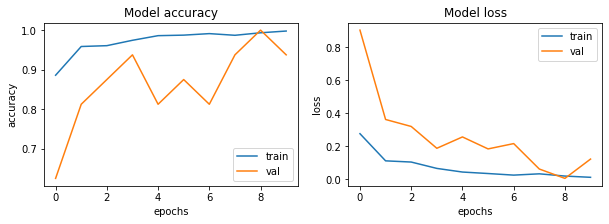

In [13]:
BATCH_SIZE = 64

training_dir = 'chest_xray/chest_xray/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_dir,
  seed=123,
  image_size=(200,200),
  batch_size=BATCH_SIZE)

validation_dir = 'chest_xray/chest_xray/val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  seed=123,
  image_size=(200,200),
  batch_size=BATCH_SIZE)

# Instatiate the normalization layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_tensors = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_tensors = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  
  layers.Dense(1, activation='sigmoid')
])

model.compile(
  optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=NUM_EPOCHS
)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [14]:
# TEST

import cv2
from sklearn.metrics import accuracy_score, confusion_matrix

# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

input_path = 'chest_xray/chest_xray/'

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (200, 200))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

preds = model.predict(test_ds)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))


CONFUSION MATRIX ------------------
[[ 26 208]
 [ 50 340]]

TEST METRICS ----------------------
Accuracy: 58.65384615384615%
Precision: 62.04379562043796%
Recall: 87.17948717948718%
F1-score: 72.4946695095949

TRAIN METRIC ----------------------
Train acc: 99.77


## Test the model

In [15]:
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix

# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

input_path = 'chest_xray/chest_xray/'

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (200, 200))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

preds = model.predict(test_ds)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))


CONFUSION MATRIX ------------------
[[ 30 204]
 [ 46 344]]

TEST METRICS ----------------------
Accuracy: 59.93589743589743%
Precision: 62.77372262773723%
Recall: 88.2051282051282%
F1-score: 73.34754797441366

TRAIN METRIC ----------------------
Train acc: 99.77
